In [1]:
import torch

torch.cuda.is_available()

True

# DATASET GENERATION

In [2]:
#!/usr/bin/env python3

import sys,os, pickle

with (open('DFGDATA.pkl' , "rb")) as openfile:
    all_input_list , all_label_list = pickle.load(openfile)






In [3]:
all_input_list = all_input_list[:100]
all_label_list = all_label_list[:100]

In [4]:
all_label_list

[1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0]

# Creating the pipeline

In [5]:
from transformers import BertTokenizer, BertForNextSentencePrediction,BertForPreTraining
import torch

# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer = BertTokenizer.from_pretrained("./multytask-tokenizer")
# model = BertForNextSentencePrediction.from_pretrained('bert-base-uncased')
model = BertForPreTraining.from_pretrained('bert-base-uncased')


Our data is now ready for tokenization, this time we truncate/pad each token to the same length of *512* tokens.

In [6]:
inputs = tokenizer(all_input_list , return_tensors='pt', 
                   max_length=64, truncation=True, padding='max_length')

In [7]:
inputs.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

We can see that the *token_type_ids* tensors have been built correctly (eg **1** indicating sentence B tokens) by checking the first instance of *token_type_ids*:

In [8]:
inputs.token_type_ids[0]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

The **0** tokens following our sentence B tokens correspond to *PAD* tokens.

Alongside this, we need to create a *labels* tensor too - which corresponds to the values contained within our `label` variable. Our *labels* tensor must be a *LongTensor*, and we will need to transpose the tensor so that it matches our other tensors' dimensionality.

In [9]:
#todo changed! was ddg label
inputs['next_sentence_label'] = torch.LongTensor([all_label_list]).T


And the labels tensor is simply a clone of the input_ids tensor before masking.

In [10]:
inputs['labels'] = inputs.input_ids.detach().clone()

In [11]:
inputs.labels[0]

tensor([    2, 16765,    23,   123, 14353,     5, 14412,    23,    93,   108,
           11,   104,    96,    24,    94,    25,     5, 15872,    23,   170,
           94,    11,   153,    96,    24,   101,    12,    17,    25,     5,
        13839,    23,   117,    94,    11,    94,     5, 17822,    23,   117,
           94,    11,   108,     5,  9847,    23,   157,   103,    11,   183,
           96,    24,    94,    25,     5, 17730,    23,   157,   103,    11,
          294,     5,     6,     3])

Now we mask tokens in the input_ids tensor using the 15% probability for MLM - ensuring we don't mask CLS, SEP, or PAD tokens.

In [12]:
# create random array of floats with equal dimensions to input_ids tensor
rand = torch.rand(inputs.input_ids.shape)
# create mask array
mask_arr = (rand < 0.15) * (inputs.input_ids != 101) * \
           (inputs.input_ids != 102) * (inputs.input_ids != 0)

In [13]:
mask_arr[0]
# inputs.input_ids.shape[0]

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False,  True, False, False,
        False,  True, False,  True, False, False,  True, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False,  True, False,  True])

And now take the indices of each True value within each vector.

In [14]:
selection = []

for i in range(inputs.input_ids.shape[0]):
    selection.append(
        torch.flatten(mask_arr[i].nonzero()).tolist()
    )

In [15]:
selection[0]

[37, 41, 43, 46, 61, 63]

Then apply these indices to each row in input_ids, assigning each value at these indices a value of 103.

In [16]:
for i in range(inputs.input_ids.shape[0]):
    inputs.input_ids[i, selection[i]] = 103

In [17]:
inputs.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'next_sentence_label', 'labels'])

The `inputs` tensors are now ready, and we can begin building the model input pipeline for training. We first create a PyTorch dataset from our data.

In [18]:
class MeditationsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    def __len__(self):
        return len(self.encodings.input_ids)

Initialize our data using the `MeditationDataset` class.

In [19]:
dataset = MeditationsDataset(inputs)

In [20]:
train_size = int(0.8 * len(dataset))
validation_size = len(dataset) - train_size

train_dataset, validation_dataset = torch.utils.data.random_split(dataset, [train_size, validation_size])

And initialize the dataloader, which we'll be using to load our data into the model during training.

In [21]:
BATCH_SIZE = 8
train_loader      = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [22]:
# 

Now we can move onto setting up the training loop. First we setup GPU/CPU usage.

In [23]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# and move our model over to the selected device
model.to(device)

BertForPreTraining(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

Activate the training mode of our model, and initialize our optimizer (Adam with weighted decay - reduces chance of overfitting).

In [24]:
from sklearn.metrics import precision_recall_fscore_support , accuracy_score
import numpy as np


Now we can move onto the training loop, we'll train for a couple of epochs (change `epochs` to modify this).

In [25]:
# odict_keys(['loss', 'prediction_logits', 'seq_relationship_logits'])

In [26]:

from numpy import *
import math
import matplotlib.pyplot as plt


def plot_graph(training_data, validation_data , label ):

    font_size = 10
    x_labels = [ i for i in range(len(training_data)) ]

    plt.ylabel(' F1 ',fontsize=font_size)
    plt.plot(x_labels, training_data , 'r') 
    plt.plot(x_labels, validation_data , 'b') 
    plt.xlabel("Epoch", fontsize=font_size)
    plt.title(label,fontsize=font_size)
    plt.legend(['Training', 'Validation'], loc='upper left')
    
    plt.savefig('./output/'+label+'.pdf')
    plt.show()



/home/raisul/anaconda3/envs/pytorch/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|                                      | 0/2 [00:00<?, ?it/s]/tmp/ipykernel_3060782/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 38.25it/s, loss=10.7]
/home/raisul/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

DBG :  dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'next_sentence_label', 'labels'])
DBG :  dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'next_sentence_label', 'labels'])
Training:   Instruction f1:  0.36363636363636365    Token f1 0.024074074074074078


  0%|                                      | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_3060782/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|█████████████████████████████| 1/1 [00:00<00:00, 225.40it/s]
/home/raisul/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use 

Validation:  Instruction F1:  0.0    Token F1:  0.050502232142857144


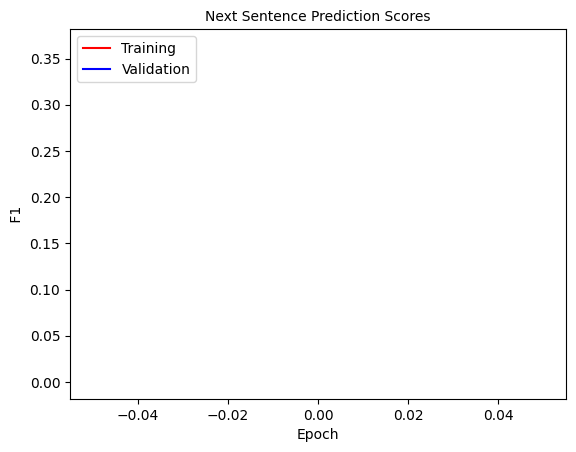

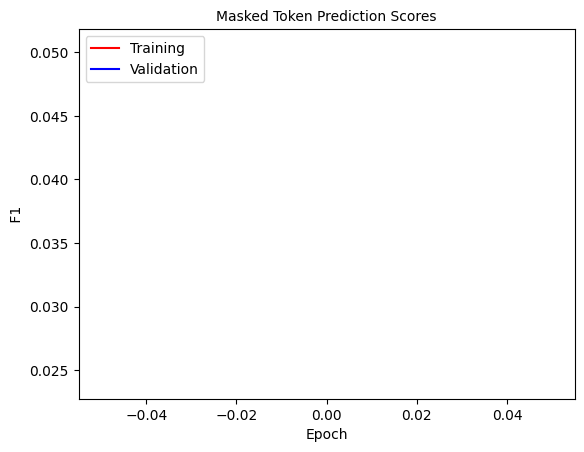

  0%|                                      | 0/2 [00:00<?, ?it/s]/tmp/ipykernel_3060782/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 1: 100%|██████████| 2/2 [00:00<00:00, 44.13it/s, loss=9.73]
/home/raisul/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use 

DBG :  dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'next_sentence_label', 'labels'])
DBG :  dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'next_sentence_label', 'labels'])
Training:   Instruction f1:  0.4615384615384615    Token f1 0.032754629629629634


  0%|                                      | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_3060782/81523791.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|█████████████████████████████| 1/1 [00:00<00:00, 226.19it/s]

Validation:  Instruction F1:  0.6666666666666666    Token F1:  0.054947916666666666



/home/raisul/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/raisul/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


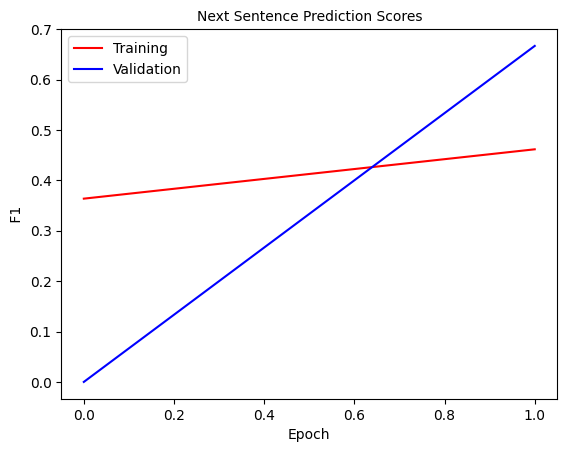

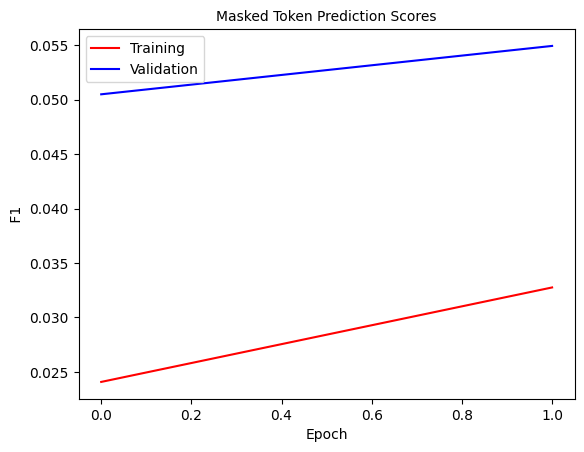

In [29]:
from transformers import AdamW
from tqdm import tqdm  # for our progress bar


# initialize optimizer
optim = AdamW(model.parameters(), lr=5e-6)



epochs = 2
counter = 0

global_instruction_metrices = []
global_token_metrices = []

v_global_instruction_metrices = []
v_global_token_metrices = []


for epoch in range(epochs):
    # setup loop with TQDM and dataloader
    train_loop = tqdm(train_loader, leave=True)
    
    
    instruction_predictions_all, instruction_ground_truths_all = None, None
    token_predictions_all, token_ground_truths_all = None, None
    
    # activate training mode
    model.train()
    for N,batch in enumerate(train_loop):

        optim.zero_grad()
        # pull all tensor batches required for training
        print("DBG : ", batch.keys())
        input_ids = batch['input_ids'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        next_sentence_label = batch['next_sentence_label'].to(device)
        labels = batch['labels'].to(device)
        # process
        outputs = model(input_ids, attention_mask=attention_mask,
                        token_type_ids=token_type_ids,
                        next_sentence_label=next_sentence_label,
                        labels=labels)


        token_prediction = torch.argmax(outputs.prediction_logits, axis=-1)

        
        token_prediction = token_prediction.detach().cpu().numpy().flatten()
        token_ground_truth = labels.detach().cpu().numpy().flatten()
        
        
        instruction_prediction = torch.argmax(outputs.seq_relationship_logits, axis=-1)
        instruction_prediction   = instruction_prediction.detach().cpu().numpy().flatten()
        instruction_ground_truth = next_sentence_label.detach().cpu().numpy().flatten()
        
        if N==0:
            instruction_predictions_all   = instruction_prediction
            instruction_ground_truths_all = instruction_ground_truth
            
            token_predictions_all         = token_prediction
            token_ground_truths_all       = token_ground_truth  
        else:
            instruction_predictions_all   = np.concatenate((instruction_predictions_all, instruction_prediction))
            instruction_ground_truths_all = np.concatenate((instruction_ground_truths_all, instruction_ground_truth))
            token_predictions_all   = np.concatenate((token_predictions_all, token_prediction))
            token_ground_truths_all = np.concatenate((token_ground_truths_all, token_ground_truth))
            

        # extract loss
        loss = outputs.loss
        # calculate loss for every parameter that needs grad update
        loss.backward()
        # update parameters
        optim.step()
        # print relevant info to progress bar
        train_loop.set_description(f'Epoch {epoch}')
        train_loop.set_postfix(loss=loss.item())
    
    
    instruction_accuracy = (accuracy_score(instruction_ground_truths_all,instruction_predictions_all))
    instruction_precision, instruction_recall, instruction_f1, _ = precision_recall_fscore_support(instruction_ground_truths_all,instruction_predictions_all, average='binary')
    
    token_accuracy = (accuracy_score(token_ground_truths_all, token_predictions_all))
    token_precision, token_recall, token_f1, _ = precision_recall_fscore_support(token_ground_truths_all,token_predictions_all,average='weighted')
    
    print("Training: ",  ' Instruction f1: ', instruction_f1 , '   Token f1',token_f1)
    global_instruction_metrices.append(instruction_f1)
    global_token_metrices.append( token_f1) 


#     continue
    ###########################################
    ###############  EVAL Validation  #########
    ###########################################

    with torch.no_grad():
        model.eval()
#         v_predictions_all, v_ground_truths_all = None, None
        
        v_instruction_predictions_all, v_instruction_ground_truths_all = None, None
        v_token_predictions_all, v_token_ground_truths_all = None, None
    
    
        validation_loop = tqdm(validation_loader, leave=True)
        for N,v_batch in enumerate(validation_loop):
            
            
            
            v_input_ids = v_batch['input_ids'].to(device)
            v_token_type_ids = v_batch['token_type_ids'].to(device)
            v_attention_mask = v_batch['attention_mask'].to(device)
            v_next_sentence_label = v_batch['next_sentence_label'].to(device)
            v_labels = v_batch['labels'].to(device)
            # process
            v_outputs = model(v_input_ids, attention_mask=v_attention_mask,
                            token_type_ids=v_token_type_ids,
                            next_sentence_label=v_next_sentence_label,
                            labels=v_labels)
        
            
            
            v_token_prediction = torch.argmax(v_outputs.prediction_logits, axis=-1)
            v_token_prediction = v_token_prediction.detach().cpu().numpy().flatten()
            v_token_ground_truth = v_labels.detach().cpu().numpy().flatten()
            v_instruction_prediction = torch.argmax(v_outputs.seq_relationship_logits, axis=-1)
            v_instruction_prediction   = v_instruction_prediction.detach().cpu().numpy().flatten()
            v_instruction_ground_truth = v_next_sentence_label.detach().cpu().numpy().flatten()



        

            if N==0:
                v_instruction_predictions_all   = v_instruction_prediction
                v_instruction_ground_truths_all = v_instruction_ground_truth

                v_token_predictions_all         = v_token_prediction
                v_token_ground_truths_all       = v_token_ground_truth  
            else:
                v_instruction_predictions_all   = np.concatenate((v_instruction_predictions_all, v_instruction_prediction))
                v_instruction_ground_truths_all = np.concatenate((v_instruction_ground_truths_all, v_instruction_ground_truth))
                v_token_predictions_all   = np.concatenate((v_token_predictions_all, v_token_prediction))
                v_token_ground_truths_all = np.concatenate((v_token_ground_truths_all, v_token_ground_truth))
            

        v_instruction_accuracy = (accuracy_score(v_instruction_ground_truths_all,v_instruction_predictions_all))
        v_instruction_precision, v_instruction_recall, v_instruction_f1, _ = precision_recall_fscore_support(v_instruction_ground_truths_all,v_instruction_predictions_all, average='binary')
        
        v_token_accuracy = (accuracy_score(v_token_ground_truths_all, v_token_predictions_all))
        v_token_precision, v_token_recall, v_token_f1, _ = precision_recall_fscore_support(v_token_ground_truths_all,v_token_predictions_all,average='weighted')
    
        print("Validation: ", "Instruction F1: ", v_instruction_f1,  "   Token F1: ",v_token_f1)
        
        v_global_instruction_metrices.append(v_instruction_f1)
        v_global_token_metrices.append(v_token_f1) 
#   
    
    plot_graph(global_instruction_metrices, v_global_instruction_metrices, 'Next Sentence Prediction Scores')
    plot_graph(global_token_metrices, v_global_token_metrices, 'Masked Token Prediction Scores')

In [28]:
# # Save the trained model weights
# training_model.save_weights("weights/wghts" + str(epoch + 1) + ".ckpt")